In [209]:
import openai
import time
import re
import requests
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score, f1_score, classification_report

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [210]:
# load API key and endpoint info from Azure AI
load_dotenv()
openai.api_type = "azure"
openai.api_version = "2023-05-15" 
openai.api_base = os.getenv("ENDPOINT")  
openai.api_key = os.getenv("KEY1")

In [211]:
df = pd.read_csv('../../data/phmrc/phmrc_adult_tokenized.csv')

In [212]:
def get_embedding(label: str) -> float:
    label = label.lower()
    if label not in label_to_score:
        print(label)
        return 0
    return label_to_score[label]

In [213]:
label_to_score = {
    'aids-tb': 0,
    'communicable': 1,
    'external': 2,
    'maternal': 3, 
    'non-communicable': 4
}

score_to_label = {
    0: 'aids-tb',
    1: 'communicable',
    2: 'external',
    3: 'maternal',
    4: 'non-communicable' 
}

colors = [(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

cod_list = label_to_score.keys()

# get score for each label

df['gs_cod_score'] = [get_embedding(x) for x in df['gs_cod']]

# Create dictionary for each COD score and its proportion
cod_proportions = df['gs_cod_score'].value_counts(normalize=True).to_dict()
cod_proportions

{4: 0.55981073488097,
 2: 0.146976193996747,
 1: 0.13425994381191778,
 0: 0.09670264675439894,
 3: 0.062250480555966284}

In [214]:
def inspect_narrative(row):
    print('Narrative: ' + df['narrative'][row])
    print('True Label: ' + df['gs_text34'][row])
    print('Broad Category: ' + df['gs_cod'][row])
    print('Embedding Representation: ' + str(label_to_score[df['gs_cod'][row]]))

In [215]:
inspect_narrative(21)

Narrative: the client thanked for service which provided in the hospital_x000d__x000d_
the client transfer death certificate to their original home [place]
True Label: other cardiovascular diseases
Broad Category: non-communicable
Embedding Representation: 4


In [216]:
# Define a function to perform the random sampling within each group
n=1
def random_sample(group):
    return group.sample(n, random_state = 2)

In [217]:
# function to take in dataframe and output fewshot prompting examples in JSON format
def make_fewshot_examples(input_df, obs, leave_out = ''):
    '''
    input_df :: pandas dataframe
    obs :: integer value number of observations for each site/COD permutation
    leave_out :: string for which site to leave out of the data frame for sampling
    This function takes a random subset of size obs from df subset for each site and COD category
    creates a user/assistant prompt example from the 'gs_cod' and 'narrative' columns
    returns all few shot examples as a list of dictionaries
    leave_out defaults to not excluding any sites
    '''
    
    # set n for random_sample function
    n = obs
    
    # subset inpute df to to all 5/6 sites other than leave_out
    exclude_df = input_df[input_df['site'] != leave_out]
    
    # Apply the sample function to each group defined by 'site' and 'gs_cod'
    subset_df = exclude_df.groupby(['site', 'gs_cod'], group_keys=False).apply(random_sample)
    
    # Reset index
    subset_df.reset_index(drop=True, inplace=True)
    
#     # output plots of COD or SITE distributions
#     subset_df['gs_cod'].value_counts().plot(kind='barh', title='COD Distribution for Subsample')
#     subset_df['site'].value_counts().plot(kind='barh', title='Site Distribution for Subsample')

    
    messages = []
    
    for i, narratives in tqdm(subset_df.iterrows()):
        narrative = narratives['narrative']
        label = narratives['gs_cod']
        
        messages.append({"role": "user", "content": narrative})
        messages.append({"role": "assistant", "content": label})
    
    print('Number of User/Assistant Pairs: ' + str(len(messages)/2))
    return messages

In [169]:
# select few shot examples
fewshot_examples = make_fewshot_examples(df, 2)

30it [00:00, 13123.60it/s]

Number of User/Assistant Pairs: 30.0


In [235]:
## Manually create fewshot examples with for 1 COD in each region

def subset_by_site_cod(df_, site, cod):
    '''
    given site and cod strings this returns the subset df
    ''' 
    
    # Create boolean masks for both 'Site' and 'Cod'
    mask_site = df['site'] == site
    mask_cod = df['gs_cod'] == cod

    # Use boolean indexing to subset the DataFrame
    subset_df = df[mask_site & mask_cod]

    return subset_df[['site', 'gs_cod', 'narrative']]

print(df['site'].unique())
print(df['gs_cod'].unique())

['mexico' 'ap' 'up' 'dar' 'bohol' 'pemba']
['non-communicable' 'communicable' 'external' 'maternal' 'aids-tb']


In [ ]:
## mexico

subset_by_site_cod(df, 'mexico', 'non-communicable')

mexico = [
    # non-communicable
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'non-communicable'},
    # communicable
        {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'communicable'},
    # external
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'external'},
    # maternal
        {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'maternal'},
    # aids-tb
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'aids-tb'}
]



## ap

subset_by_site_cod(df, 'ap', 'non-communicable')

ap = [
    # non-communicable
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'non-communicable'},
    # communicable
        {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'communicable'},
    # external
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'external'},
    # maternal
        {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'maternal'},
    # aids-tb
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'aids-tb'}
]

## up

subset_by_site_cod(df, 'up', 'non-communicable')

up = [
    # non-communicable
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'non-communicable'},
    # communicable
        {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'communicable'},
    # external
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'external'},
    # maternal
        {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'maternal'},
    # aids-tb
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'aids-tb'}
]

## dar

subset_by_site_cod(df, 'dar', 'non-communicable')

dar = [
    # non-communicable
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'non-communicable'},
    # communicable
        {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'communicable'},
    # external
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'external'},
    # maternal
        {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'maternal'},
    # aids-tb
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'aids-tb'}
]

## bohol

subset_by_site_cod(df, 'bohol', 'non-communicable')

bohol = [
    # non-communicable
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'non-communicable'},
    # communicable
        {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'communicable'},
    # external
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'external'},
    # maternal
        {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'maternal'},
    # aids-tb
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'aids-tb'}
]

## pemba

subset_by_site_cod(df, 'pemba', 'non-communicable')

pemba = [
    # non-communicable
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'non-communicable'},
    # communicable
        {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'communicable'},
    # external
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'external'},
    # maternal
        {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'maternal'},
    # aids-tb
    {'role': 'user',
  'content': ''},
    {'role': 'assistant', 'content': 'aids-tb'}
]

In [171]:
predictions_classic = pd.read_csv('../classic_nlp/baseline_predictions.csv')
# predictions_bert = pd.read_csv('../transformer_nlp/ansformer_nlp/predictions_bert.csv')

predictions_gtp35_zeroshot = pd.read_csv('gpt35_zeroshot_score.csv')
predictions_gtp35_zeroshot_text = pd.read_csv('gpt35_zeroshot_text.csv')

predictions_gtp35_fewshot = pd.read_csv('gpt35_fewshot_score.csv')
predictions_gtp35_fewshot_text = pd.read_csv('gpt35_fewshot_text.csv')

predictions_gpt432k_zeroshot = pd.read_csv('gpt4-32k_zeroshot_score.csv')
predictions_gpt432k_zeroshot_text = pd.read_csv('gpt4-32k_zeroshot_text.csv')

predictions_gpt432k_fewshot = pd.read_csv('gpt-4-32k_fewshot_score.csv')
predictions_gpt432k_fewshot_text = pd.read_csv('gpt-4-32k_fewshot_text.csv')

In [172]:
accuracy_df = predictions_classic.copy()
# accuracy_df['predictions_BERT'] = predictions_bert
accuracy_df['predictions_GPT35_zeroshot'] = predictions_gtp35_zeroshot
accuracy_df['predictions_GPT35_fewshot'] = predictions_gtp35_fewshot
accuracy_df['predictions_GPT4-32k_zeroshot'] = predictions_gpt432k_zeroshot
accuracy_df['predictions_GPT4-32k_fewshot'] = predictions_gpt432k_fewshot


accuracy_df = accuracy_df.rename(columns={"predictions_NB": "NB", 
                            "predictions_SVM": "SVM", 
                            "predictions_KNN": "KNN",
                            "predictions_GPT35_zeroshot": "GPT35_zeroshot",
                            "predictions_GPT35_fewshot": "GPT35_fewshot",
                            "predictions_GPT4-32k_zeroshot": "GPT4-32k_zeroshot",
                            "predictions_GPT4-32k_fewshot": "GPT4-32k_fewshot"})

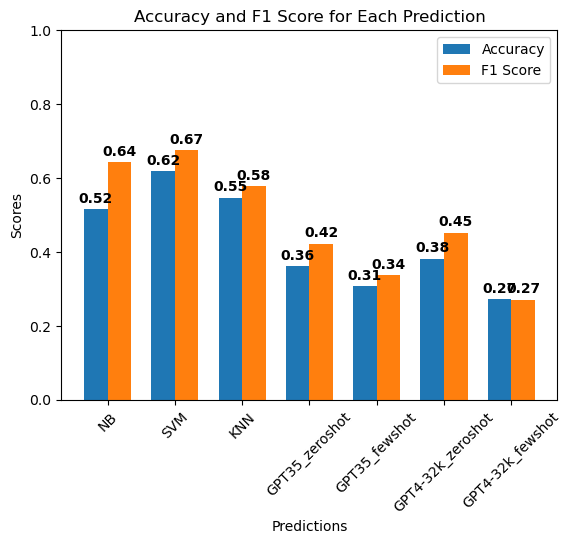

In [173]:
# Calculate accuracy and F1 score for each prediction column
columns_to_evaluate = ['NB', 'SVM', 'KNN', 'GPT35_zeroshot', 
                       'GPT35_fewshot', 'GPT4-32k_zeroshot', 'GPT4-32k_fewshot']
accuracy_scores = []
f1_scores = []

for column in columns_to_evaluate:
    accuracy = accuracy_score(accuracy_df[column], accuracy_df['Test_Y'])
    f1 = f1_score(accuracy_df[column], accuracy_df['Test_Y'] , average = 'weighted')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Plot the results
fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(columns_to_evaluate))

bar1 = ax.bar(index, accuracy_scores, bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, f1_scores, bar_width, label='F1 Score')

ax.set_xlabel('Predictions')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Score for Each Prediction')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(columns_to_evaluate)
plt.xticks(rotation=45)
ax.legend()
# Set y-axis range to 0-1
ax.set_ylim(0, 1)

# Add scores on top of each bar
for i, (acc, f1) in enumerate(zip(accuracy_scores, f1_scores)):
    ax.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom', color='black', fontweight='bold')
    ax.text(i + bar_width, f1 + 0.01, f'{f1:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

# Inspect text outputs

In [181]:
# get list of unclassified text responses from gpt, 

def unclassified_subset(text_predictions):
    '''
    get the list of all unclassified predictions
    print true label dist
    return new df with original narrative, true label, and prediction
    '''

    unclassified = text_predictions[~text_predictions.isin(cod_list)].dropna()
    indices = unclassified.index
    
    result = df.iloc[indices][['narrative', 'gs_cod']]
    result['prediction'] = unclassified
    return result

def plot_subset_dist(text_predictions):
    '''
    get the list of all unclassified predictions
    plots the distribution of true labels
    '''
    
    unclassified = text_predictions[~text_predictions.isin(cod_list)].dropna()
    indices = unclassified.index
    

    df.iloc[indices]['gs_cod'].value_counts().plot.barh(title='COD Dist', color = colors).invert_yaxis()
    

## GPT-3.5 zeroshot


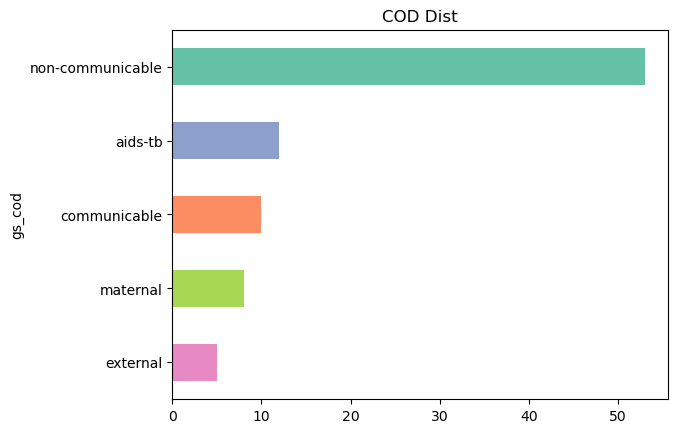

In [183]:
plot_subset_dist(predictions_gtp35_zeroshot_text)

In [184]:
unclassified_subset(predictions_gtp35_zeroshot_text)

,narrative,gs_cod,prediction
76,no.smooth interview. the informant was very nice.,non-communicable,No label applies to the narrative.
198,"no further commentsat the beginning of the interview, the informant did not want to give it because she felt it was not important. however, when i insisted on the study objective and made her realize what benefits might come of it, she agreed to give the interview, and it went well.",non-communicable,No label applies to the narrative.
306,the client said that the service was good,communicable,None of the labels apply to the narrative as it does not provide any information related to the cause of the patient's death.
345,respondent had nothing to add,non-communicable,No label applies to the narrative as the respondent had nothing to add.
425,participant thanked very much for services which provided by nurses and doctors especially [hospital],communicable,None of the labels apply to the narrative as it does not describe the cause of the patient's death.
...,...,...,...
6374,nothe interview went smoothly. the interviewee was very cooperative.,non-communicable,Not enough information is provided in the narrative to determine which label best applies.
6413,no further commentsthe interview flowed smoothly.,non-communicable,There is not enough information in the narrative to determine which label best applies.
6450,[person] did not wish to add anything else.the interview went smoothly.,non-communicable,There is not enough information in the narrative to determine which label best applies.
6641,the client thanked for services which provided by nurses and in the hospital especial [hospital]._x000d__x000d_\nthe client claimed serviced which provided in [hospital2].,non-communicable,There is not enough information in the narrative to determine which label best applies.


## GPT-3.5 fewshot

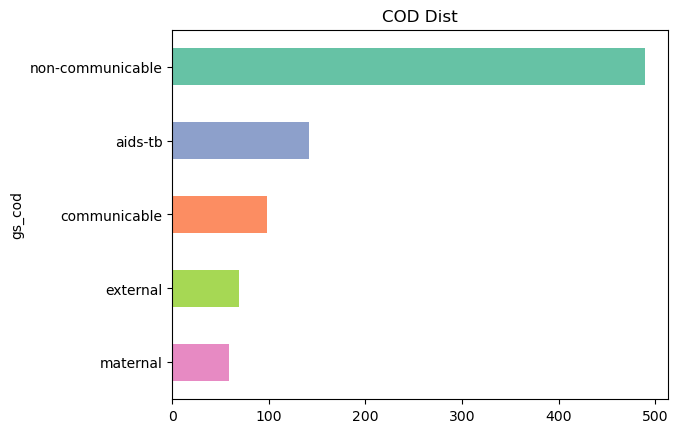

In [185]:
plot_subset_dist(predictions_gtp35_fewshot_text)

In [186]:
unclassified_subset(predictions_gtp35_fewshot_text)

,narrative,gs_cod,prediction
13,respondent thanked for being visited,aids-tb,I cannot provide a label without a narrative. Please provide a narrative for me to analyze.
15,"they are interested in people's health, it does not make sense that they say personal treatment is not relevant, as it is part of this study. there should be a committee that supervises these institutions where poor care is provided and the patients' relatives are badly treated. will this study really be followed up? for the sake of the people that participated in it...emotional support. cellphone: [phone] [person] home :[phone2] stopped eating 2-61 was unconscious",external,It is not clear which label applies to the narrative as there is no specific information provided about the cause of death.
19,client had no additional point,non-communicable,Please provide the narrative for me to label.
23,no comment,communicable,I cannot provide a label without a narrative. Please provide the narrative.
42,the death certificate has been taken by their daughter to ourservice,non-communicable,"I'm sorry, but I cannot provide a label without a narrative. Please provide the narrative for me to analyze."
...,...,...,...
6724,the client has nothing to suggest,communicable,I cannot provide a label without a narrative. Please provide a narrative for me to analyze.
6727,the participant thanked for the service,aids-tb,"I'm sorry, but I cannot provide a response without a narrative to analyze. Please provide a narrative for me to analyze."
6747,participant had no nothing to add,non-communicable,"I'm sorry, but I cannot provide a label without a narrative. Please provide the narrative for me to analyze."
6755,client had no additional point,non-communicable,"I'm sorry, but I cannot provide a label without a narrative. Please provide the narrative for me to analyze."


## GPT-4k-32k zeroshot

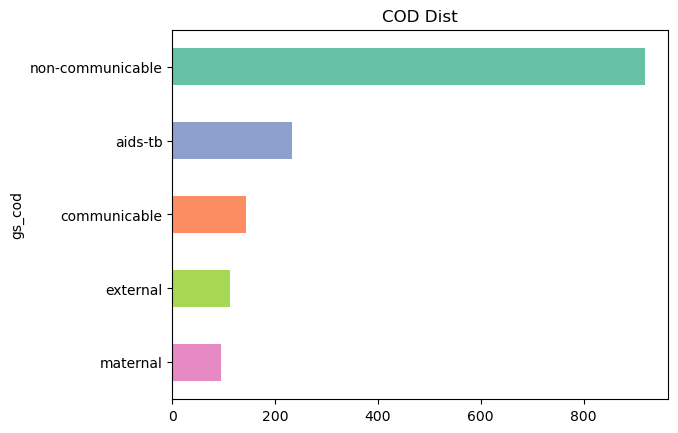

In [187]:
plot_subset_dist(predictions_gpt432k_zeroshot_text)

In [188]:
unclassified_subset(predictions_gpt432k_zeroshot_text)

,narrative,gs_cod,prediction
13,respondent thanked for being visited,aids-tb,The narrative does not provide enough information to determine a cause of death.
19,client had no additional point,non-communicable,The narrative does not provide enough information to determine the appropriate label.
21,the client thanked for service which provided in the hospital_x000d__x000d_\nthe client transfer death certificate to their original home [place],non-communicable,The narrative does not provide enough information to determine the cause of death.
22,the client thanked for the service,communicable,The narrative does not provide information related to any of the labels.
23,no comment,communicable,The narrative does not provide enough information to determine the cause of death.
...,...,...,...
6755,client had no additional point,non-communicable,The narrative does not provide enough information to determine the appropriate label.
6756,the client had nothing to say,aids-tb,The narrative does not provide enough information to determine a cause of death.
6757,no further comments,non-communicable,The narrative does not provide enough information to determine the cause of death.
6759,the participant had nothing to comment on_x000d__x000d_\nnb:death certificate has been misplaced,non-communicable,The narrative does not provide enough information to determine a cause of death.


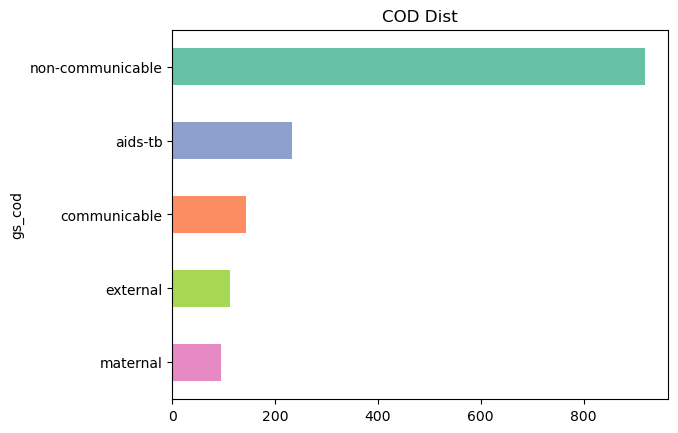

In [189]:
## GPT-4k-32k zeroshot

plot_subset_dist(predictions_gpt432k_zeroshot_text)

In [190]:
unclassified_subset(predictions_gpt432k_zeroshot_text)

,narrative,gs_cod,prediction
13,respondent thanked for being visited,aids-tb,The narrative does not provide enough information to determine a cause of death.
19,client had no additional point,non-communicable,The narrative does not provide enough information to determine the appropriate label.
21,the client thanked for service which provided in the hospital_x000d__x000d_\nthe client transfer death certificate to their original home [place],non-communicable,The narrative does not provide enough information to determine the cause of death.
22,the client thanked for the service,communicable,The narrative does not provide information related to any of the labels.
23,no comment,communicable,The narrative does not provide enough information to determine the cause of death.
...,...,...,...
6755,client had no additional point,non-communicable,The narrative does not provide enough information to determine the appropriate label.
6756,the client had nothing to say,aids-tb,The narrative does not provide enough information to determine a cause of death.
6757,no further comments,non-communicable,The narrative does not provide enough information to determine the cause of death.
6759,the participant had nothing to comment on_x000d__x000d_\nnb:death certificate has been misplaced,non-communicable,The narrative does not provide enough information to determine a cause of death.


In [191]:
# reset display 
pd.reset_option('display.max_columns', None)
pd.reset_option('display.max_colwidth', None)